# Алгоритм SIPP и его модификации

### Описание проекта

В этом проекте будет рассматриваться задача планирования траектории на сетчатых 4-connected графах с динамическими препятствиями. Целью проекта является реализация и сравнение алгоритмов:
- **AStar with timesteps**
- **SIPP**
- **Sub-optimal SIPP (WSIPP)**
- **Naive Anytime SIPP**
- **Anytime SIPP (ARSIPP)**

Все алгоритмы будут использовать манхэттеновскую эвристикy.

Алгоритм SIPP реализован без перераскрытий, так как доказано, что с такой эвристикой его решение будет оптимальным и без использования перераскрытий. 

Sub-optimal SIPP реализован с использованием перераскрытий, чтобы гарантировать суб-оптимальность.

Naive Anytime SIPP реализован с помощью последовательных запусков Sub-optimal SIPP с уменьшением параметра *w*.

.. про ARSIPP

Для начала импортируем все необходимые пакеты, вспомогательные функции и структуры и реализации алгоритмов:

In [25]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import time

from heapq import heappop, heappush, heapify
from random import randint
from IPython.display import HTML
from PIL import Image, ImageDraw, ImageOps
from IPython.display import Image as Img
from IPython.display import display
from sys import float_info
from datetime import datetime
from tqdm import tqdm

EPS = float_info.epsilon
%matplotlib notebook

In [26]:
from src.grid import Map, SafeMap, manhattan_distance
from src.utils import make_path, draw

In [27]:
from src.algo.astar_timesteps import astar_timesteps, SearchTree as SearchTreeAStarTimesteps
from src.algo.sipp import sipp, SearchTree as SearchTreeSIPP
from src.algo.wsipp import wsipp, SearchTree as SearchTreeWSIPP
from src.algo.naive_arsipp import naive_arsipp

### Описание хода эксперимента

Основной задачей было тестирование на картах с динамическими препятствиями, поэтому для сбора статистики были выбраны 4 карты: одна маленькая и 3 большие, обладающие разными свойствами.

Для каждой карты была вручную выбрана конфигурация расположения старта и цели.

Далее для каждой карты были случайным образом (с воспроизводимостью) сгенерированы 5 для маленькой и 50 для каждой большой карты конфигураций динамических препятствий. Количество динамических препятствий у конфигурации линейно зависит от её порядкового номера. 

Препятствия генерируются следующим образом: длина траектории (от 3 до 12), стартовая клетка пути и переходы на соседние клетки в таком количестве, чтобы соответствовало длине траектории. По стартовой клетке и переходам формируется список позиций траектории. Далее к нему в конец добавляется этот же список, но без первой и последней позиции и в обратном направлении. Когда препятствие достигает конца списка позиций, оно продолжает с начала списка, что формирует замкнутую траекторию, повторяющую себя в обоих направлениях.

Далее собирается статистика для каждого запуска на карте с конкретной конфигурацией динамических препятствий.

### Описание используемых карт

При сборе статистики используются 3 карты (можно посмотреть их изображения ниже): 
- **small**: маленькая карта-лабиринт
- **32room_007**: лабиринт комнат с узкими проходами между свободными пространствами.
- **Paris_1_512**: город с достатоным объемом свободного пространства
- **random512-15-0**: рандомная карта-шум с большим количеством статических препятствий

<table><tr>
<td> <img src="./images/small.jpg" alt="32room_007" style="width: 400px;"/> </td>
<td> <img src="./images/32room_007.png" alt="32room_007" style="width: 200px;"/> </td>
<td> <img src="./images/Paris_1_512.png" alt="Paris_1_512" style="width: 200px;"/> </td>
<td> <img src="./images/random512_15_0.png" alt="random512_15_0" style="width: 200px;"/> </td>
</tr></table>


Карты отличаются общей идеей построения, внешним видом и плотностью расположения препятствий.

Карта **small** маленькая, простая и наглядная. На ней может быть удобнее отслеживать простые зависимости.

На карте **32room_007** узкие проходы соединяют свободные пространства. Это может давать интересные результаты при различных расположениях препятствий.

На карте **Paris_1_512** много широких проходов. Ожидается, что препятствия будут не слишком сильно мешать построению пути.

Карта **random512-15-0** довольно сильно загружена статическими препятствиями, что делает интересным добавление ещё и динамических препятствий.

### Описание собираемых статистик

В собираемую во время каждого запуска статистику входят:
- найден ли путь
- длина найденного пути
- во сколько раз найденный путь длиннее оптимального (для WSIPP)
- количество шагов алгоритма
- количество созданных *Node*
- количество раскрытий
- время работы

Перечисленные показатели дают информацию о:
- оптимальности решений алгоритма
- времени работы (количество шагов и фактическое) 
- использованной памяти

Этих параметров должно хватать для оценки и сравнения предложенных для исследования алгоритмов.

In [4]:
def generate_dynamic_obstacles_confs(count, height, width):    
    delta = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
    
    tasks = []
    
    def foo(num):
        return 50 + 5 * num
    
    for num in range(count):
        confs = []
        for i_obs in range(foo(num)):
            l = np.random.choice(range(3, 13))
            conf = []
            i = np.random.choice(height)
            j = np.random.choice(width)
            conf.append((i, j))
            deltas = delta[np.random.choice(4, size=l-1)]
            for pos in range(1, l):
                conf.append((conf[pos-1][0] + deltas[pos-1][0], conf[pos-1][1] + deltas[pos-1][1])) 

            conf = conf + conf[-2:0:-1]
            conf_res = []
            for _ in range(100):
                conf_res = conf_res + conf
            confs.append(conf_res)
        
        tasks.append(confs)
    
    return tasks


In [30]:
def launch_astar_timesteps(file_name, tasks_count, *args):
    np.random.seed(100)
    from src.algo.astar_timesteps import CATable, Node
        
    map_path = "maps/" + file_name + ".map"    
    grid = Map()
    grid.read_from_file(map_path)
    
    scens_path = "scens/" + file_name + ".map.scen"     
    scens_file = open(scens_path) 
    start_i, start_j, goal_i, goal_j = list(map(lambda i: int(i), scens_file.readline().split()))
        
    stat = dict()
    stat["wasFind"] = []
    stat["lenght"] = []
#     stat["coef"] = []
    stat["steps"] = []
    stat["nodesCreated"] = []
    stat["time"] = []
    
    tasks = generate_dynamic_obstacles_confs(tasks_count, grid.get_size()[0], grid.get_size()[1])
    
    for i, task in tqdm(enumerate(tasks)):
        try:   
            ca_table = CATable(task)
            
            start_time = datetime.now()
            result = astar_timesteps(grid, ca_table, start_i, start_j, goal_i, goal_j, *args)
            runtime = datetime.now() - start_time   
            
            stat["wasFind"].append(result[0])
            stat["steps"].append(result[2])
            stat["nodesCreated"].append(result[3])
            stat["time"].append(runtime)
            
            if result[0]:
                path = make_path(result[1]) 
                stat["lenght"].append(path[1])
            
#                 coef = path[1] / expected_len
#                 stat["coef"].append(coef)
                
                print("Path found! Length: " + str(path[1]) +\
                    ". Nodes created: " + str(result[3]) + \
                    ". Number of steps: " + str(result[2]) + \
                    ". Time: " + str(runtime))
                
            else:
                stat["lenght"].append(0.0)
                print("Path not found!")
            
        except Exception as e:
            print("Execution error")
            print(e)
        
    return stat


In [29]:
small = launch_astar_timesteps("small", 5, manhattan_distance, SearchTreeAStarTimesteps)


2it [00:00, 11.12it/s]

Path found! Length: 57. Nodes created: 8407. Re-exp: 2146. Number of steps: 2147. Time: 0:00:00.063509
Path found! Length: 59. Nodes created: 11435. Re-exp: 2934. Number of steps: 2935. Time: 0:00:00.085599
Path found! Length: 60. Nodes created: 9319. Re-exp: 2546. Number of steps: 2547. Time: 0:00:00.071458


5it [00:00, 11.66it/s]

Path found! Length: 59. Nodes created: 8982. Re-exp: 2535. Number of steps: 2536. Time: 0:00:00.071671
Path found! Length: 54. Nodes created: 5982. Re-exp: 1599. Number of steps: 1600. Time: 0:00:00.048152


In [23]:
def launch(file_name, search_func, tasks_count, *args):
    from src.algo.astar_timesteps import CATable, Node
        
    map_path = "maps/" + file_name + ".map"    
    grid = Map()
    grid.read_from_file(map_path)
    
    scens_path = "scens/" + file_name + ".map.scen"     
    scens_file = open(scens_path) 
    start_i, start_j, goal_i, goal_j = list(map(lambda i: int(i), scens_file.readline().split()))
        
    stat = dict()
    stat["wasFind"] = []
    stat["lenght"] = []
#     stat["coef"] = []
    stat["steps"] = []
    stat["nodesCreated"] = []
    stat["time"] = []
    
    tasks = generate_dynamic_obstacles_confs(tasks_count, grid.get_size()[0], grid.get_size()[1])
    
    for i, task in tqdm(enumerate(tasks)):
#         try:   
            safe_task_map = SafeMap(grid, task)
            
            start_time = datetime.now()
            result = search_func(safe_task_map, start_i, start_j, goal_i, goal_j, *args)
            runtime = datetime.now() - start_time   
            
            stat["wasFind"].append(result[0])
            stat["steps"].append(result[2])
            stat["nodesCreated"].append(result[3])
            stat["time"].append(runtime)
            
            if result[0]:
                path = make_path(result[1]) 
                stat["lenght"].append(path[1])
            
#                 coef = path[1] / expected_len
#                 stat["coef"].append(coef)
                
                print("Path found! Length: " + str(path[1]) +\
                    ". Nodes created: " + str(result[3]) + \
                    ". Number of steps: " + str(result[2]) + \
                    ". Time: " + str(runtime))
                
            else:
                stat["lenght"].append(0.0)
                print("Path not found!")
            
#         except Exception as e:
#             print("Execution error")
#             print(e)
        
    return stat


In [24]:
small = launch("small", sipp, 5, manhattan_distance, SearchTreeSIPP)


1it [00:00,  1.70it/s]

Path found! Length: 54. Nodes created: 26543. Number of steps: 388. Time: 0:00:00.411042


2it [00:01,  1.81it/s]

Path found! Length: 57. Nodes created: 24123. Number of steps: 393. Time: 0:00:00.308820


3it [00:01,  1.88it/s]

Path found! Length: 54. Nodes created: 27085. Number of steps: 374. Time: 0:00:00.280940


4it [00:02,  1.79it/s]

Path found! Length: 55. Nodes created: 26976. Number of steps: 369. Time: 0:00:00.384536


5it [00:02,  1.71it/s]

Path found! Length: 60. Nodes created: 31413. Number of steps: 580. Time: 0:00:00.454170


In [19]:
from src.tests import simple_test, simple_test_anytime, simple_test_timesteps

## Experimental evaluation

Path found! Length: 48. Nodes created: 1432. Number of steps: 311. Correct: True


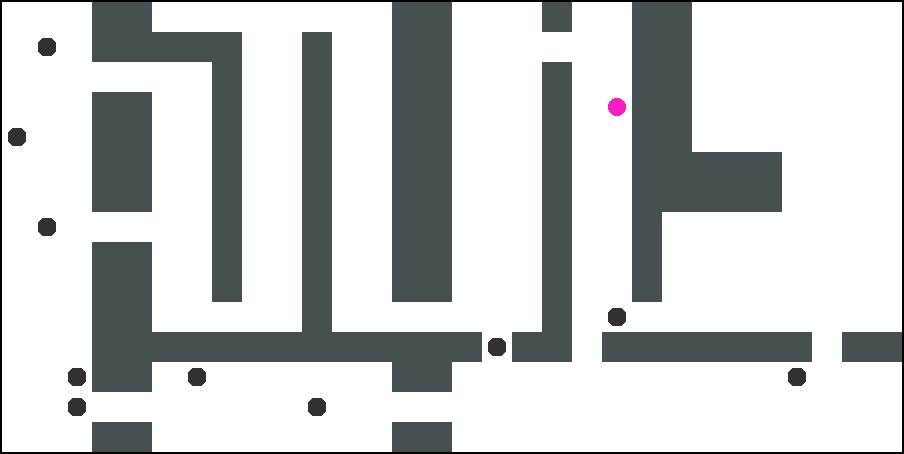

CPU times: user 3.69 s, sys: 332 ms, total: 4.02 s
Wall time: 4.04 s


In [20]:
%time simple_test(sipp, 2, manhattan_distance, SearchTreeSIPP)

Path found! Length: 48. Nodes created: 1432. Number of steps: 311. Correct: True


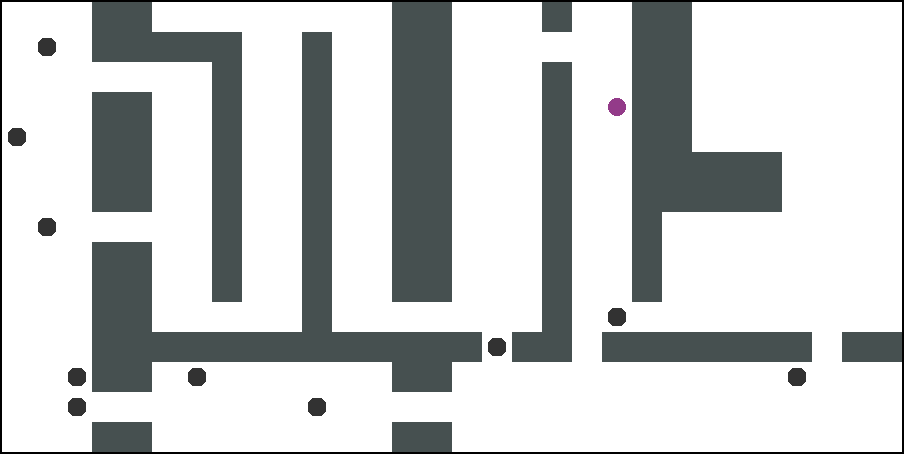

CPU times: user 3.62 s, sys: 374 ms, total: 3.99 s
Wall time: 3.99 s


In [6]:
%time simple_test(sipp, 2, manhattan_distance, SearchTreeSIPP)

Path found! Length: 48. Nodes created: 13328. Number of steps: 3318. Correct: True


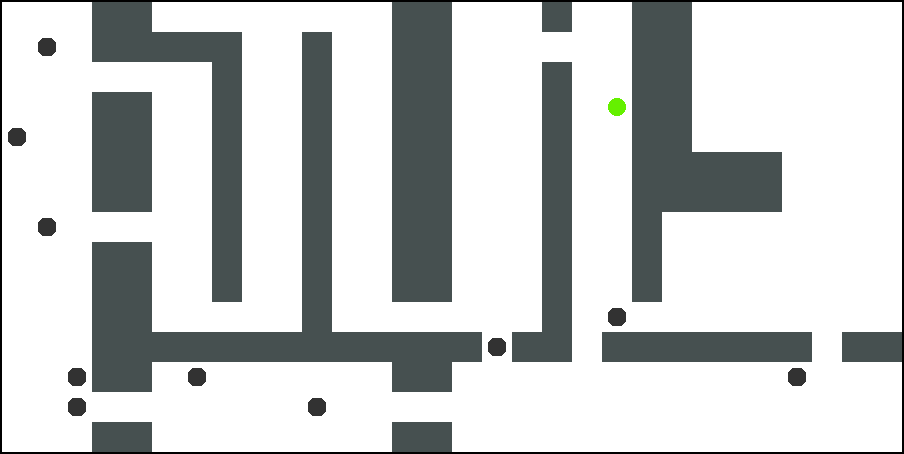

CPU times: user 3.95 s, sys: 393 ms, total: 4.34 s
Wall time: 4.34 s


In [8]:
%time simple_test_timesteps(astar_timesteps, 2, manhattan_distance, SearchTreeAStarTimesteps)

Path found! Length: 48. Nodes created: 1432. Number of steps: 311. Correct: True


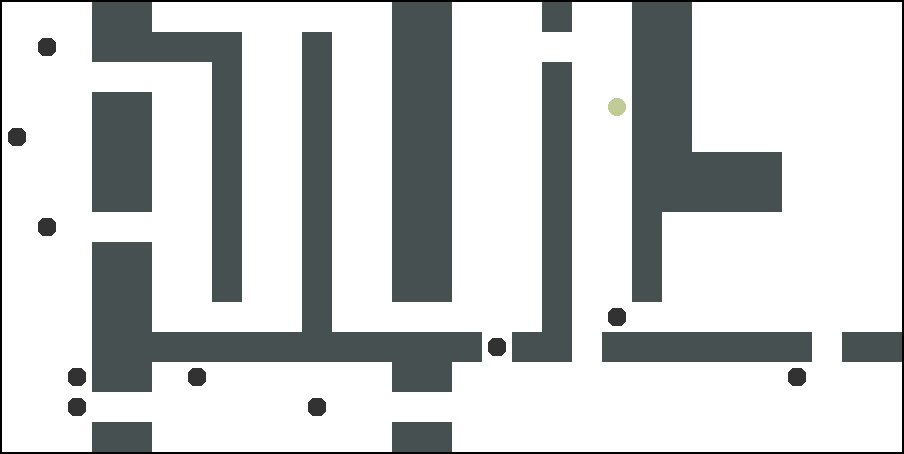

CPU times: user 3.76 s, sys: 368 ms, total: 4.12 s
Wall time: 4.12 s


In [12]:
%time simple_test(wsipp, 2, 1, manhattan_distance, SearchTreeWSIPP)

# Anytime SIPP

In [49]:
from src.algo.arsipp import SearchTree as ST, Node

In [52]:
def improve_path(goal_i, goal_j, safe_grid_map, heuristic_func, ast, weight):
    steps = 0
    
    while not ast.open_is_empty():
        def get_node_best():
            goal_in_visited = ast.get_node(goal_i, goal_j)
            if goal_in_visited.f <= ast._open[0].f:
                return goal_in_visited
            return ast.get_best_node_from_open()
            
        node = get_node_best()
                
        if node is None:
            return False, None, steps
        if node.i == goal_i and node.j == goal_j:
            return True, node, steps
        
        def apply(neighbor):
            return Node(
                i=neighbor[0],
                j=neighbor[1], 
                g=neighbor[2],
                interval = safe_grid_map.get_interval(neighbor[0], neighbor[1], neighbor[2]),
                h=heuristic_func(neighbor[0], neighbor[1], goal_i, goal_j),
                w=weight,
                parent=node)
            
        successors = list(map(apply, safe_grid_map.get_neighbors(node.i, node.j, node.g)))
    
        for _, successor in enumerate(successors):   
            successor_in_visited = ast.get_node(successor.i, successor.j)
            if successor_in_visited.g == math.inf:
                ast.add_to_open(successor)
            else:
                if ast.was_expanded(successor):
                    if successor.g < successor_in_visited.g:
                        ast.add_to_incons(successor)
                else:
                    if successor.g < successor_in_visited.g:
                        ast.add_to_open(successor)
                
        ast.add_to_closed(node)
        steps += 1
    
    return False, None, steps


def arsipp(safe_grid_map,
            start_i, start_j,
            goal_i, goal_j,
            start_w = 3.0,
            step_w = 0.5,
            heuristic_func = None,
            search_tree = None):
    '''
    Runs Anytime Repairing A* search algorithm.

    Parameters
    ----------
    grid_map : Map
        An additional domain information (such as grid map).
    start_i, start_j : int, int
        The start state of search in useful for your implementation form.
    goal_i, goal_j  : int, int
        The goal state of search in useful for your implementation form.
    start_w : float
        The initial weight of heuristics in F-value computation. Must be greater or equal to 1.0, by default 3.0.
    step_w : float
        The value by which the weight will be reduced, if it is provided by the algorithm, by default 0.5.

    Yields
    -------
    path_found : bool
        Path was found or not.  
    last_node : Node
        The last node in path. None if path was not found.
    steps : int
        The number of search steps
    weight : float
        Weight used at iteration
    '''
    
    if start_w < 1:
        raise Exception("Weight must be greater or equal to 1")

    weight = float(start_w)
    steps = 0
    
    if not safe_grid_map.traversable(start_i, start_j, 0):
        Exception("Bad start:", start_i, start_j)
    
    start_node = Node(start_i,start_j,
                      g=0.0,
                      w=weight,
                      h=heuristic_func(start_i, start_j, goal_i, goal_j),
                      interval=0)
    
    start_node.f = start_node.g + weight * start_node.h

    arast = search_tree()
    arast.add_to_open(start_node)

    while True:
        path_found, goal_node, iter_steps = improve_path(goal_i, goal_j, safe_grid_map, heuristic_func, arast, weight)

        steps += iter_steps
        yield path_found, goal_node, steps, weight

        if abs(weight - 1.0) < EPS:
            break
            
        weight = (weight - step_w) if (weight - step_w) >= 1.0 else 1.0
 
        arast.unite_update_open_incons(weight)
        arast.clear_incons()
        arast.clear_closed()
        

In [55]:
%time simple_test_anytime(arsipp, 4, 2.7, 0.1, 0.02, manhattan_distance, ST)


A* Path found! Length: 56.0000000
1 iter (w = 2.700). Real sub-optimality value: 1.393
2 iter (w = 2.600). Real sub-optimality value: 1.393
3 iter (w = 2.500). Real sub-optimality value: 1.393
4 iter (w = 2.400). Real sub-optimality value: 1.393
5 iter (w = 2.300). Real sub-optimality value: 1.393
6 iter (w = 2.200). Real sub-optimality value: 1.393
7 iter (w = 2.100). Real sub-optimality value: 1.393
8 iter (w = 2.000). Real sub-optimality value: 1.000
Weighted path found! Final sub-optimality value: 1.0000000. Iterations: 8. Time: 0.01658607
CPU times: user 52.9 ms, sys: 3.63 ms, total: 56.5 ms
Wall time: 54.4 ms


(True, 56, 1.0)

In [9]:
%time simple_test_anytime(naive_arsipp, 4, 3, 0.1, 0.02, manhattan_distance, SearchTreeWSIPP)


A* Path found! Length: 56.0000000
1 iter (w = 3.000). Real sub-optimality value: 1.429
Weighted path found! Final sub-optimality value: 1.4285714. Iterations: 2. Time: 0.01532888
CPU times: user 73.8 ms, sys: 0 ns, total: 73.8 ms
Wall time: 72.3 ms


(True, 80, 1.4285714285714286)